In [21]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [267]:
# Converting image into black white
cat_bw = np.array(Image.open('cat_text.jpg').convert('1'))
hello_bw = np.array(Image.open('hello_text.jpg').convert('1'))

In [ ]:
def convolution(data: list, kernel: list):
    return

In [259]:
def edge_detection(data: list, display: bool = False) -> list:
    """ Filters the input, so edges are visible
    Input:
        - data: input image
        - display: show the result filtered image
    Return: 
        - Filtered image array
    """
    h = np.array([1, 0, -1])
    rows, cols = data.shape
    y_rows = np.zeros(data.shape)
    for i in range(rows):
        y_rows[i,:] = signal.convolve(data[i,:], h, 'same')

    y_cols = np.zeros(data.shape)
    for i in range(cols):
        y_cols[:, i] = signal.convolve(data[:, i], h, 'same')

    y_IF = np.sqrt(y_rows**2 + y_cols**2)
    if (display):
        plt.figure(figsize=(10,6))
        plt.imshow(y_IF, 'gray')
        plt.title('Gradient')
    return y_IF

In [260]:
def char_col_finder(data: list) -> list[tuple]:
    """ Find column indices of character(s)
    Input:
        - data: input image
    Return:
        - List of column pair indices that contains a character
    """
    col = []
    found = False
    pair = []
    for c in range(data.shape[1]):
        if c + 1 <= data.shape[1]:
            found = False
            # Find White 1.0 <
            for p in data[:, c:c+1]:
                if p >= 1.0:
                    found = True
                    break
            if len(pair) == 0 and found and c != 0:
                pair.append(c)
            elif len(pair) == 1 and not found:
                pair.append(c)
                col.append(pair)
                pair = []
    return col

In [261]:
def char_row_finder(data: list) -> []:
    """ Find the min and max row indices that exists a white pixel
    Input:
        - data: input image
    Return:
        - top and bottom indices
    """
    top = data.shape[0]
    bottom = 0

    for r in range(data.shape[0]):
        if r + 1 <= data.shape[0]:
            for p in data[r:r+1, 5:data.shape[1]-5][0]:
                if p >= 1.0:
                    if r < top:
                        top = r if r != 0 else top
                    if r > bottom:
                        bottom = r if r != data.shape[0]-1 else bottom
                    break
    return [top, bottom]

        

In [263]:
def show_cropped_char(crop_array: list):
    """ Display the cropped characters
    Input:
        - crop_array: list of cropped image
    """
    for i in range(len(crop_array)):
        plt.subplot(1, len(crop_array), i + 1)
        plt.imshow(crop_array[i])
    plt.show()

In [264]:
def text_segmentation(data: list, display: bool = False) -> []:
    """ Segments an image with characters into individual characters
    Input:
        - data: input image
    Return:
        - List of cropped characters from input
    """
    edge_array = edge_detection(data=data, display=True)
    # crop top and bottom, since those will be edges too
    top, bottom = char_row_finder(edge_array)
    cropped_array = edge_array[top:bottom, :]

    # find the column indices pairs of each found character
    cutoff_col_idx = char_col_finder(cropped_array)

    characters = []
    
    for (c0, c1) in cutoff_col_idx:
        characters.append(cropped_array[:, c0:c1])

    if display:
        show_cropped_char(characters)

    return characters

/var/folders/7b/kf4t784j2k9gn4kmpt_pktsw0000gn/T/ipykernel_1497/1063090301.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, len(crop_array), i + 1)


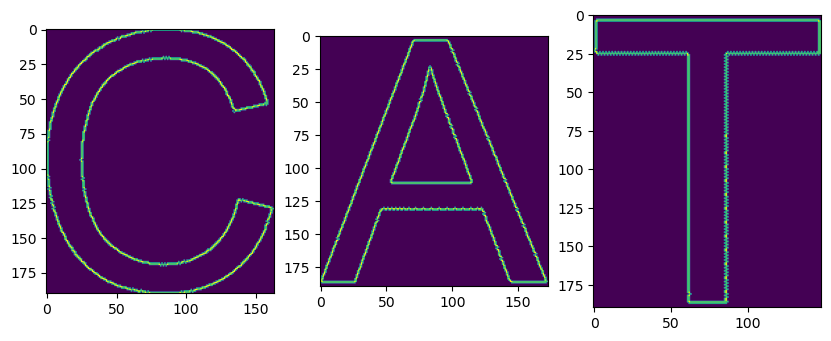

In [268]:
cropped_data = text_segmentation(data=cat_bw, display=True)

/var/folders/7b/kf4t784j2k9gn4kmpt_pktsw0000gn/T/ipykernel_1497/1063090301.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, len(crop_array), i + 1)


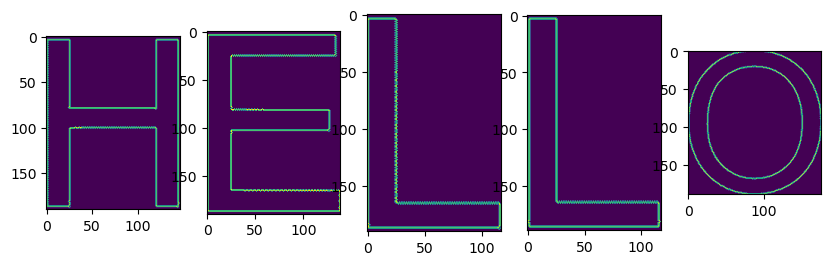

In [269]:
cropped_data = text_segmentation(data=hello_bw, display=True)